In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

#Although there are some warnings that were useful for clarifying elements of the models that could be tuned, for the most part this statement is being used to clean up the output of the models.
#The code below has been cleaned up to the point where the only remaining warnings are not constructive ones.
import warnings
warnings.filterwarnings('ignore')

EXPORT_PATH = r'C:\Users\mulla\Documents\Python\Java\project_data'
WEATHER_FOLDER = r'C:\Users\mulla\Documents\Python\Java\nc_weather'

In [2]:
%time

weather = pd.DataFrame()
for fname in Path(WEATHER_FOLDER).glob('*/*'):
    if (fname.suffix != '.csv'): 
        continue
    df = pd.read_csv(fname)
    weather = pd.concat([weather, df])

weather = weather.reset_index(drop=True)
weather.set_index('DateUTC', inplace=True)

Wall time: 0 ns


In [3]:
#Setting a benchmark value. In this case, as precipitation is normally very low, the RMSE from predicting that it is always zero should be fairly low. Resulting RMSE multiplied by 100 for ease of comparison.
weather['PrecipitationIn'] = weather['PrecipitationIn'].fillna(0)
mode_val = weather['PrecipitationIn'].mode()[0]
weather['Prediction'] = mode_val
dumbtest = np.sqrt(metrics.mean_squared_error(weather['PrecipitationIn'], weather['Prediction']))*100
print(dumbtest)

5.593124930930565


In [4]:
#At this point, there are a lot of data values that are either missing or impossible to work with for a regression model, so even before building out a model, some columns will be dropped and have
#some cleanup done. There are redundancies in the columns which should be addressed early.

#'TimeEST' and 'TimeEDT' are secondary to 'DateUTC', and furthermore both have half their values missing due to Daylight Savings Time.
#'Wind Direction' can be very helpful for a hypothetical expanded model that predicts weather across a large area, but in this specific case will not be useful as there is a numeric 'WindDirDegrees' column.
#'Events' seems to be a generalization of 'Conditions'. 'Events', appropriately mapped to numerical categories, would be simpler to work with, but 'Conditions' would likely give the better model.

#All of the above features can be dropped before even beginning to work on a model because they are inherently pointless to the stated problem, and furthermore require complicated cleanup in some cases.
#'WindDirDegrees', as an already numerical value, can be left in, but I fully expect it to have very low relevance and be removed as a result.

weather['Conditions_Num'] = weather.Conditions.map({'Mostly Cloudy':0, 'Overcast':1, 'Scattered Clouds':2, 'Partly Cloudy':3,
                                               'Clear':4,'Light Rain':5, 'Light Drizzle':6, 'Fog':7, 'Patches of Fog':8,
                                               'Rain':9,'Thunderstorm':10,'Light Thunderstorms and Rain':11,
                                               'Heavy Thunderstorms and Rain':12,'Thunderstorms and Rain':13,
                                                'Light Snow':14,'Heavy Rain':15,'Light Freezing Rain':16,'Light Freezing Drizzle':17,
                                                'Haze':18,'Drizzle':19,'Light Ice Pellets':20,'Light Freezing Fog':21,
                                               'Ice Pellets':22,'Snow':23,'Heavy Drizzle':24,'Heavy Snow':25,'Heavy Ice Pellets':26,
                                               'Shallow Fog':27,'Unknown':28})

weather['Wind SpeedMPH'] = weather['Wind SpeedMPH'].replace('Calm', 0)
weather['Gust SpeedMPH'] = weather['Gust SpeedMPH'].str.replace('-','')
weather['Wind SpeedMPH'] = pd.to_numeric(weather['Wind SpeedMPH'])
weather['Gust SpeedMPH'] = pd.to_numeric(weather['Gust SpeedMPH'])
#Gust Speed is proving to be a particularly annoying column due to the initial dataframe being filled with '-0' values that are also strings. Another fillna method is necessary here.
weather['Gust SpeedMPH'] = weather['Gust SpeedMPH'].fillna(0)
weather['Humidity'] = weather['Humidity'].fillna(weather['Humidity'].mean())


In [5]:
#Creating feature list, splitting data into training and testing sets, and applying scaler.
feature_cols = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','Conditions_Num','WindDirDegrees']

X = weather[feature_cols]
y = weather['PrecipitationIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
numlist = []
results = []
for num in range (1,51):
    treereg = DecisionTreeRegressor(max_depth=num,random_state=42)
    treereg.fit(X_train_scaled, y_train)

    treereg_predictions = treereg.predict(X_test_scaled)
    scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')

    numlist.append(num)
    results.append(np.mean(np.sqrt(-scores))*100)  #RMSE multiplied by 100 for ease of comparison with benchmark.


Text(0, 0.5, 'RMSE (lower is better)')

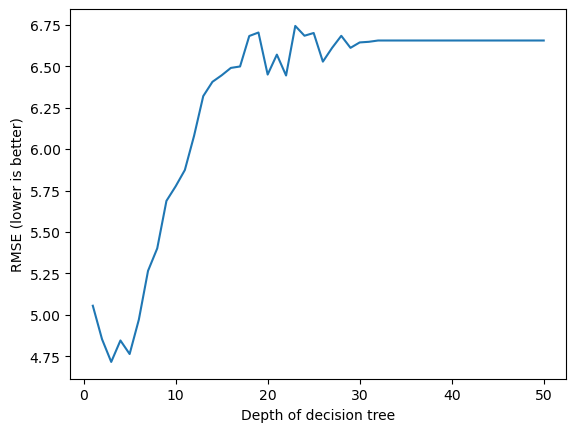

In [7]:
plt.plot(numlist, results)
plt.xlabel('Depth of decision tree')
plt.ylabel('RMSE (lower is better)')

In [8]:
#After testing the model on a number of max_depth values, 3 and 5 gave the best results. For the feature importance test, 5 will be chosen as the most likely indicator.
treereg = DecisionTreeRegressor(max_depth=5,random_state=42)
treereg.fit(X_train_scaled, y_train)

treereg_predictions = treereg.predict(X_test_scaled)
scores = cross_val_score(treereg, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
print(np.mean(np.sqrt(-scores))*100)

pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

5.96505837178805


,feature,importance
0,TemperatureF,0.104292
1,Dew PointF,0.018868
2,Humidity,0.252103
3,Sea Level PressureIn,0.001029
4,VisibilityMPH,0.068853
5,Wind SpeedMPH,0.000000
6,Gust SpeedMPH,0.000591
7,Conditions_Num,0.553789
8,WindDirDegrees,0.000475


In [9]:
#IMPORTANT OBSERVATION: Increasing the max_depth parameter past 5 dramatically worsened the model's performance, and a key factor in this seemed to be that WindDirDegrees was being assigned 
#more and more importance. After max_depth = 10 or so, the model was performing worse than the benchmark test.

#The above model gives a slightly worse result than the benchmark. Predictably, wind direction was virtually irrelevant, as was gust speed, and wind speed was not at all relevant.
#As a result of this feature importance table, all wind metrics can safely be excluded from consideration in this and future modeling.

In [10]:
#Redefining features, splitting into new sets, and applying scaler.
feature_cols = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Conditions_Num']

X = weather[feature_cols]
y = weather['PrecipitationIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
%%time
#Decision Tree Regressor model.

treereg = DecisionTreeRegressor(max_depth=5,random_state=42)
treereg.fit(X_train_scaled, y_train)

treereg_predictions = treereg.predict(X_test_scaled)
scores = cross_val_score(treereg, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
treereg_result = (np.mean(np.sqrt(-scores))*100)

print(treereg_result)

pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

5.613923043171618
Wall time: 101 ms


,feature,importance
0,TemperatureF,0.104326
1,Dew PointF,0.018874
2,Humidity,0.252184
3,Sea Level PressureIn,0.001030
4,VisibilityMPH,0.068893
5,Conditions_Num,0.554693


In [12]:
%%time
#Linear Regression model.
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

linreg_predictions = linreg.predict(X_test_scaled)
scores = cross_val_score(linreg, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
linreg_result = (np.mean(np.sqrt(-scores))*100)

print(linreg_result)

6.018516660869921
Wall time: 56.8 ms


In [13]:
#I did not expect Linear Regression to be at all a good model due to the imbalance in target values (most PrecipitationIn values are 0, but there are also some relative outliers that
#would inevitably over time skew a linear model horribly.) The RMSE was nowhere near as large as I had expected, but nonetheless the model performed worse than Decision Tree.

In [14]:
%%time
#Random Forest model.
rfreg = RandomForestRegressor(min_samples_split=3,max_depth=6,n_estimators=94)
rfreg.fit(X_train_scaled, y_train)
scores = cross_val_score(rfreg, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
rfreg_result = (np.mean(np.sqrt(-scores))*100)

print(rfreg_result)

5.430050115954726
Wall time: 7.78 s


In [32]:
#Random Forest was the best model by a small margin, providing a roughly 10% improvement over the benchmark RMSE.

In [16]:
#Other fields can be predicted as well. A potentially valuable field would be to predict categorical weather conditions based on available data, so the next model is a Logistic Regression model
#predicting 'Conditions'

#Setting the benchmark.
dumbtest_cat = weather.Conditions.value_counts()[0]/weather.shape[0]
print(dumbtest_cat)

0.3168319566838863


In [17]:
feature_cols_cat = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','PrecipitationIn','WindDirDegrees']

X = weather[feature_cols_cat]
y = weather['Conditions']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
%%time
logreg = LogisticRegression(multi_class='multinomial',max_iter=1500)
logreg.fit(X_train_scaled,y_train)

y_pred = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
logreg_predictions = np.round(logreg.predict_proba(X_test_scaled), decimals=2)
print(logreg_predictions)

                              precision    recall  f1-score   support

                       Clear       0.33      0.23      0.27       704
                     Drizzle       0.00      0.00      0.00        10
                         Fog       0.17      0.13      0.15        90
                        Haze       0.00      0.00      0.00         9
                  Heavy Rain       0.00      0.00      0.00        26
Heavy Thunderstorms and Rain       0.44      0.30      0.36        46
                 Ice Pellets       0.00      0.00      0.00         5
               Light Drizzle       0.00      0.00      0.00       126
      Light Freezing Drizzle       0.00      0.00      0.00        14
          Light Freezing Fog       0.00      0.00      0.00         3
         Light Freezing Rain       0.00      0.00      0.00        23
           Light Ice Pellets       0.00      0.00      0.00         3
                  Light Rain       0.53      0.37      0.43       574
                  L

In [19]:
#Although ultimately both the weighted precision and recall scores are slightly above the benchmark test, the logistic regression model was not overly successful in predicting weather conditions.
#Possible reasons for this are that there are a wide variety of weather conditions which are broadly similar in scope. This is a case in which either the 'events' column previously dropped could be used,
#or some manual reassignment of the various elements in 'Conditions' can be concatenated at the programmer's discretion. This will be attempted below.

In [20]:
#Suggested concatenations are as follows:
#'Mostly Cloudy', 'Overcast', and 'Partly Cloudy' will be mapped to category 'Cloudy'
#'Scattered Clouds' and 'Clear' will be mapped to 'Clear'
#'Light Rain','Light Drizzle','Drizzle','Rain', 'Heavy Rain', and 'Heavy Drizzle' will be mapped to 'Rainy'
#'Fog','Patches of Fog','Shallow Fog','Haze', and 'Unknown' will be mapped to 'Foggy.' By all rights, 'Unknown' should be dropped, but as there are only two instances of it, it is unlikely to impact the 
#precision of the model appreciably. As is, manual review of 'unknown' conditions places it closest to the Foggy conditions.
#'Thunderstorm','Light Thunderstorms and Rain','Heavy Thunderstorms and Rain', and 'Thunderstorms and Rain' will be mapped to 'Stormy'
#'Light snow','Light Freezing Rain','Light Freezing Drizzle','Light Ice Pellets','Ice Pellets', and 'Light Freezing Fog' will be mapped to 'Light Cold'
#'Ice Pellets','Snow','Heavy Snow', and 'Heavy Ice Pellets' will be mapped to 'Heavy Cold'


weather['Conditions_General'] = weather.Conditions.map({'Mostly Cloudy':'Cloudy', 'Overcast':'Cloudy', 'Scattered Clouds':'Clear', 'Partly Cloudy':'Cloudy',
                                               'Clear':'Clear','Light Rain':'Rainy', 'Light Drizzle':'Rainy', 'Fog':'Foggy', 'Patches of Fog':'Foggy',
                                               'Rain':'Rainy','Thunderstorm':'Stormy','Light Thunderstorms and Rain':'Stormy',
                                               'Heavy Thunderstorms and Rain':'Stormy','Thunderstorms and Rain':'Stormy',
                                                'Light Snow':'Light Cold','Heavy Rain':'Rainy','Light Freezing Rain':'Light Cold','Light Freezing Drizzle':'Light Cold',
                                                'Haze':'Foggy','Drizzle':'Rainy','Light Ice Pellets':'Light Cold','Light Freezing Fog':'Light Cold',
                                               'Ice Pellets':'Heavy Cold','Snow':'Heavy Cold','Heavy Drizzle':'Rainy','Heavy Snow':'Heavy Cold','Heavy Ice Pellets':'Heavy Cold',
                                               'Shallow Fog':'Foggy','Unknown':'Foggy'})


In [21]:
#Restructuring the data once more. Also creating a scaler, as scaled data will be used for every subsequent model.
feature_cols_cat = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','PrecipitationIn','WindDirDegrees']

X = weather[feature_cols_cat]
y = weather['Conditions_General']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

dumbtest_cat_restructured = weather.Conditions_General.value_counts()[0]/weather.shape[0]
print(dumbtest_cat_restructured)

0.6146854885494074


In [22]:
%%time
#New Logistic Regression Model.
logreg = LogisticRegression(multi_class='multinomial',max_iter=1500)
logreg.fit(X_train_scaled,y_train)

y_pred = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
logreg_predictions = np.round(logreg.predict_proba(X_test_scaled), decimals=2)
print(logreg_predictions)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

              precision    recall  f1-score   support

       Clear       0.39      0.03      0.05      2220
      Cloudy       0.64      0.97      0.77      5536
       Foggy       0.29      0.08      0.13       174
  Heavy Cold       0.00      0.00      0.00         8
  Light Cold       0.50      0.08      0.13        77
       Rainy       0.69      0.36      0.47       817
      Stormy       0.64      0.25      0.36       218

    accuracy                           0.64      9050
   macro avg       0.45      0.25      0.27      9050
weighted avg       0.58      0.64      0.54      9050

[[0.3  0.68 0.   ... 0.   0.   0.03]
 [0.38 0.61 0.   ... 0.   0.   0.01]
 [0.44 0.55 0.   ... 0.   0.   0.  ]
 ...
 [0.14 0.62 0.09 ... 0.   0.13 0.02]
 [0.12 0.73 0.01 ... 0.   0.11 0.03]
 [0.26 0.73 0.   ... 0.   0.   0.  ]]
0.639889502762431
Wall time: 8.95 s


In [23]:
#Predictably, lowering the number of outcome categories dramatically increased the recall of the model. However, the new benchmark, when calculated, also drastically improved.
#The resulting model offers a roughly 2% improvement over the new benchmark test and in this sitaution that cannot count as much of a success.
#One interesting observation is that removing wind-related data actually LOWERED the accuracy of the model slightly; this makes some sense, as wind is more directly tied to weather phenomena outside of
#precipitation; in particular, the 'Foggy' category suffered in accuracy when wind considerations were removed. 
#One significant improvement may be to find implied categories between multiple different feature interactions, which could be better represented by a Decision Tree Classifier or KNN model, both of which
#are slightly better suited to handling data that has natural clusters.

In [24]:
depth_range=list(range(1,11))
sample_range=list(range(2,121))
param_grid = dict(max_depth=depth_range,min_samples_split=sample_range)

decision_tree = DecisionTreeClassifier()

In [25]:
%%time
#Grid Search for max_depth and min_samples_split
grid = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled,y_train)

grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]

print(grid.best_score_)
print(grid.best_params_)

0.6795091634958159
{'max_depth': 8, 'min_samples_split': 2}
Wall time: 7min 36s


In [26]:
%%time
decision_tree = DecisionTreeClassifier(max_depth=8,min_samples_split=2,random_state=42)
decision_tree.fit(X_train_scaled, y_train)

y_pred = decision_tree.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       Clear       0.48      0.16      0.24      2220
      Cloudy       0.69      0.91      0.78      5536
       Foggy       0.67      0.49      0.57       174
  Heavy Cold       0.50      0.75      0.60         8
  Light Cold       0.68      0.65      0.67        77
       Rainy       0.71      0.63      0.67       817
      Stormy       0.68      0.28      0.39       218

    accuracy                           0.67      9050
   macro avg       0.63      0.55      0.56      9050
weighted avg       0.64      0.67      0.62      9050

0.6722651933701658
Wall time: 372 ms


In [27]:
#A Decision Tree classifier performed noticeably better, offering a ~10% increase in accuracy over the benchmark test. Overall, however, these models do not come as close to a desired accuracy of ~80%
#as could be hoped. As a result, the actual applicability of these models is debatable, though they do offer some value. The DT model was particularly poor for predicting clear conditions ('Clear' had a
#recall value of 16%, by far the lowest of the group), most likely because they have the broadest spectrum of possible environments. Stormy environments were also not particularly successfully predicted,
#but I believe that is due to the conditions of 'Stormy' being the least well-segregated; further refinement of target categories could drastically improve performance.

In [28]:
neighbor_range = list(range(30,71))
weight_option = ['distance','uniform']
p_option = [1,2]
param_grid = dict(n_neighbors=neighbor_range,weights=weight_option, p=p_option)

knn = KNeighborsClassifier()

In [29]:
%%time
#Grid Search for hyperparameters. Initially more hyperparameters were included, but the vast majority had negligible (less than 0.01%) impact on the model, if any at all. Range for n_neighbors was also
#previously much larger, but has been reduced for ease of rerunning the code.
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled,y_train)

grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6595820684700233
{'n_neighbors': 43, 'p': 1, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=43, p=1)
Wall time: 18min 29s


In [30]:
%%time
#KNN Classifier.
knn = KNeighborsClassifier(n_neighbors=43, weights='uniform',p=1)
knn.fit(X_train_scaled, y_train)

predictions = knn.predict(X_test_scaled)
print(accuracy_score(y_test, predictions))

0.6549171270718233
Wall time: 2.39 s


In [31]:
#KNN did not perform quite as well as expected, but still offered an improvement over both LogReg and the benchmark test. Barring a custom weights formula (surprisingly 'uniform' was the better option of
#the two predetermined ones,) I do not think that any of the other hyperparameters would impact the model's performance noticeably. The most likely and perhaps only significant improvement to be made is
#further refinement of the input data itself.